In [4]:
### svm algometric with euledian distance and wordtovec
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import AgglomerativeClustering
from sklearn.svm import SVC
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
from nltk.tokenize import word_tokenize
import PyPDF2

# Read job descriptions and skills dataset
job_desc_df = pd.read_csv('indeed_dataset.csv', encoding="latin-1")
skills_df = pd.read_csv('skills1.csv')

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in word_tokenize(text) if word.isalpha()])  # Remove non-alphabetic characters
    return text

# Extract skills from job descriptions
def extract_skills(text, skills_df):
    skills = set()
    for skill in skills_df['skills']:
        if skill.lower() in text.lower():
            skills.add(skill.lower())
    return list(skills)

# Create a list of skills extracted from job descriptions
all_skills = []
for text in job_desc_df['description']:
    skills = extract_skills(text, skills_df)
    all_skills.extend(skills)

# Train Word2Vec model on extracted skills
word2vec_model_skills = Word2Vec([all_skills], min_count=1)

# Function to get vector representation of a text
def get_text_vector(text, model):
    tokens = word_tokenize(text)
    vector = np.zeros(model.vector_size)
    count = 0
    for token in tokens:
        if token in model.wv.index_to_key:
            vector += model.wv[token]
            count += 1
    if count != 0:
        vector /= count
    return vector

# Cluster job descriptions based on skill vectors
job_desc_df['vector'] = job_desc_df['description'].apply(lambda x: get_text_vector(x, word2vec_model_skills))
X = np.array(job_desc_df['vector'].tolist())
clustering = AgglomerativeClustering(n_clusters=5)
job_desc_df['cluster'] = clustering.fit_predict(X)

# Prepare data for classification
X_train, X_test, y_train, y_test = train_test_split(X, job_desc_df['cluster'], test_size=0.25, random_state=42)

# Train SVM classifier
svm_clf = make_pipeline(StandardScaler(), SVC())
svm_clf.fit(X_train, y_train)

# Function to extract text from a PDF file
def extract_text_from_pdf(file_path):
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page_num in range(len(reader.pages)):
            text += reader.pages[page_num].extract_text()
    return text

# Extract text from your resume PDF
resume_text = extract_text_from_pdf('resume_yash.pdf')

# Preprocess resume text
resume_text = preprocess_text(resume_text)

# Extract skills from resume
resume_skills = extract_skills(resume_text, skills_df)

# Predict cluster for resume
predicted_cluster = svm_clf.predict([get_text_vector(resume_text, word2vec_model_skills)])[0]

# Calculate precision, recall, and F1 score for classification model
y_pred = svm_clf.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nClassification Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print()
print("\nSkills Extracted from Resume:", resume_skills)
print()
# Find top 5 jobs based on Euclidean distance
job_desc_df['euclidean_distance'] = job_desc_df['vector'].apply(lambda x: euclidean_distances([get_text_vector(resume_text, word2vec_model_skills)], [x])[0][0])
similar_jobs = job_desc_df[job_desc_df['cluster'] == predicted_cluster].sort_values(by='euclidean_distance').head(5)

print("\nTop 5 Similar Jobs with Title, Link, Skills, and Euclidean Similarity:")
for index, row in similar_jobs.iterrows():
    print("\nTitle:", row['title'])
    print("Link:", row['link'])
    print("Euclidean Similarity:", row['euclidean_distance'])
    job_skills = extract_skills(row['description'], skills_df)  # Get skills for each job from job descriptions
    print("Skills from Job Description:", job_skills)



Classification Metrics:
Precision: 0.9915356151711378
Recall: 0.9914893617021276
F1 Score: 0.9914401979836232


Skills Extracted from Resume: ['functional', 'backend ', 'express', 'android', 'data ', 'r', ' development ', 'languages', 'java', 'database ', 'chef', 'go', 'frontend', 'kotlin', 'git', ' engineering ', 'sql', 'cloud ']


Top 5 Similar Jobs with Title, Link, Skills, and Euclidean Similarity:

Title: Consultant ï¿½ï¿½ï¿½ Web Dev
Link: https://www.indeed.co.in/rc/clk?jk=59edad14d3066caa&from=jasx&tk=1hng1miccic9i800&bb=BmxtsrZZsRS2o0pZPm2ozP3Fv6kReVuXFLfSttdgFN8s17Xf9uL7KGJD88v6bnCn81ALBbmYOpCmGz-SgMClusPzKZzPT8WMGq0kokLmL2M1T6M3HpgUVQ%3D%3D&xkcb=SoDp67M3EwLVlPQFgJ0BbzkdCdPP&vjs=3
Euclidean Similarity: 0.03930830017069156
Skills from Job Description: ['html', 'angular', 'docker', 'data ', 'languages', 'r', 'sql', 'git', 'laravel', 'web ', 'programming ', ' development ', 'php', 'database ', 'java', 'https', 'frameworks', 'javascript', 'serverless', 'functional', 'mean', 'boot


Classification Metrics:
Precision: 0.987303801883502
Recall: 0.9872340425531915
F1 Score: 0.9871908362430606


Skills Extracted from Resume: ['functional', 'backend ', 'express', 'android', 'data ', 'r', ' development ', 'languages', 'java', 'database ', 'chef', 'go', 'frontend', 'kotlin', 'git', ' engineering ', 'sql', 'cloud ']


Top 5 Similar Jobs with Title, Link, Skills, and Euclidean Similarity:

Title: Consultant ï¿½ï¿½ï¿½ Web Dev
Link: https://www.indeed.co.in/rc/clk?jk=59edad14d3066caa&from=jasx&tk=1hng1miccic9i800&bb=BmxtsrZZsRS2o0pZPm2ozP3Fv6kReVuXFLfSttdgFN8s17Xf9uL7KGJD88v6bnCn81ALBbmYOpCmGz-SgMClusPzKZzPT8WMGq0kokLmL2M1T6M3HpgUVQ%3D%3D&xkcb=SoDp67M3EwLVlPQFgJ0BbzkdCdPP&vjs=3
Euclidean Similarity: 0.03930830017069156
Skills from Job Description: ['html', 'angular', 'docker', 'data ', 'languages', 'r', 'sql', 'git', 'laravel', 'web ', 'programming ', ' development ', 'php', 'database ', 'java', 'https', 'frameworks', 'javascript', 'serverless', 'functional', 'mean', 'boots

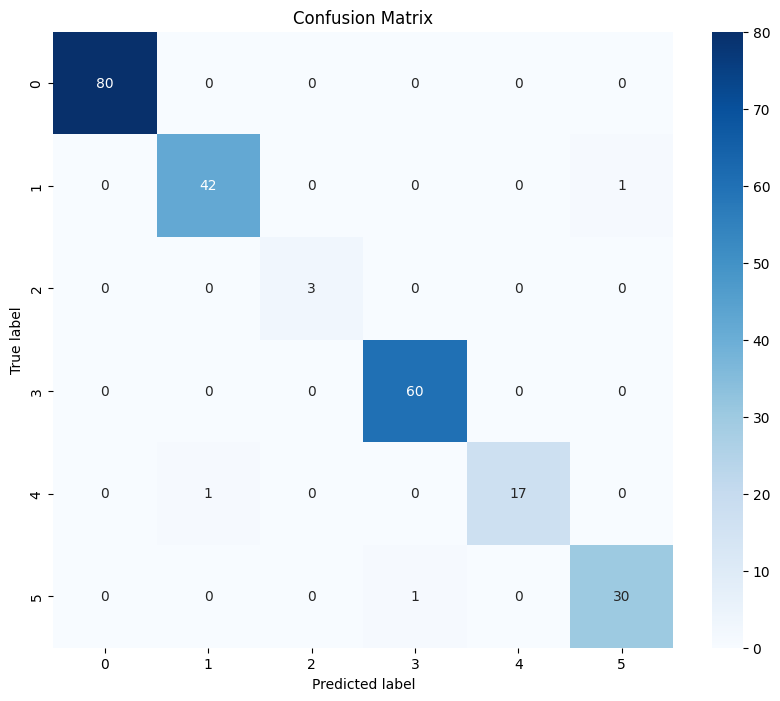

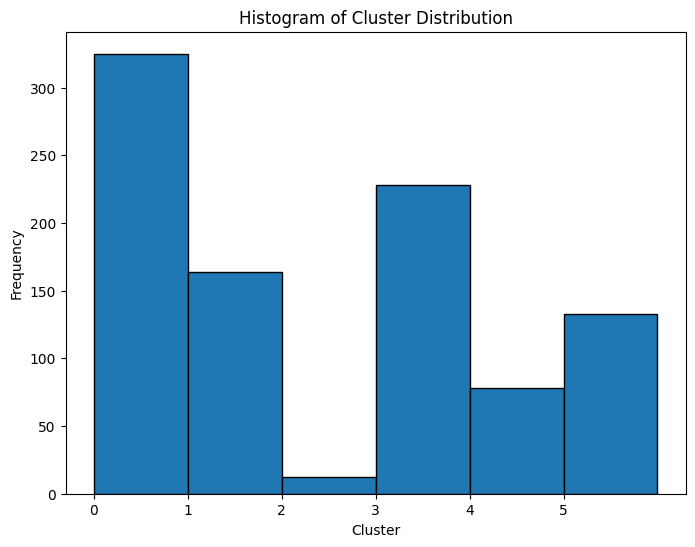

In [21]:
##svm with all graphs 
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import AgglomerativeClustering
from sklearn.svm import SVC
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


from nltk.tokenize import word_tokenize
import PyPDF2

# Read job descriptions and skills dataset
job_desc_df = pd.read_csv('indeed_dataset.csv', encoding="latin-1")
skills_df = pd.read_csv('skills1.csv')

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in word_tokenize(text) if word.isalpha()])  # Remove non-alphabetic characters
    return text

# Extract skills from job descriptions
def extract_skills(text, skills_df):
    skills = set()
    for skill in skills_df['skills']:
        if skill.lower() in text.lower():
            skills.add(skill.lower())
    return list(skills)

# Create a list of skills extracted from job descriptions
all_skills = []
for text in job_desc_df['description']:
    skills = extract_skills(text, skills_df)
    all_skills.extend(skills)

# Train Word2Vec model on extracted skills
word2vec_model_skills = Word2Vec([all_skills], min_count=1)

# Function to get vector representation of a text
def get_text_vector(text, model):
    tokens = word_tokenize(text)
    vector = np.zeros(model.vector_size)
    count = 0
    for token in tokens:
        if token in model.wv.index_to_key:
            vector += model.wv[token]
            count += 1
    if count != 0:
        vector /= count
    return vector

# Cluster job descriptions based on skill vectors
job_desc_df['vector'] = job_desc_df['description'].apply(lambda x: get_text_vector(x, word2vec_model_skills))
X = np.array(job_desc_df['vector'].tolist())
clustering = AgglomerativeClustering(n_clusters=6)
job_desc_df['cluster'] = clustering.fit_predict(X)

# Prepare data for classification
X_train, X_test, y_train, y_test = train_test_split(X, job_desc_df['cluster'], test_size=0.25, random_state=42)

# Train SVM classifier
svm_clf = make_pipeline(StandardScaler(), SVC(probability=True))
svm_clf.fit(X_train, y_train)

# Function to extract text from a PDF file
def extract_text_from_pdf(file_path):
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page_num in range(len(reader.pages)):
            text += reader.pages[page_num].extract_text()
    return text

# Extract text from your resume PDF
resume_text = extract_text_from_pdf('resume_yash.pdf')

# Preprocess resume text
resume_text = preprocess_text(resume_text)

# Extract skills from resume
resume_skills = extract_skills(resume_text, skills_df)

# Predict cluster for resume
predicted_cluster = svm_clf.predict([get_text_vector(resume_text, word2vec_model_skills)])[0]

# Calculate precision, recall, and F1 score for classification model
y_pred = svm_clf.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nClassification Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print()
print("\nSkills Extracted from Resume:", resume_skills)
print()
# Find top 5 jobs based on Euclidean distance
job_desc_df['euclidean_distance'] = job_desc_df['vector'].apply(lambda x: euclidean_distances([get_text_vector(resume_text, word2vec_model_skills)], [x])[0][0])
similar_jobs = job_desc_df[job_desc_df['cluster'] == predicted_cluster].sort_values(by='euclidean_distance').head(5)

print("\nTop 5 Similar Jobs with Title, Link, Skills, and Euclidean Similarity:")
for index, row in similar_jobs.iterrows():
    print("\nTitle:", row['title'])
    print("Link:", row['link'])
    print("Euclidean Similarity:", row['euclidean_distance'])
    job_skills = extract_skills(row['description'], skills_df)  # Get skills for each job from job descriptions
    print("Skills from Job Description:", job_skills)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_mat = confusion_matrix(y_test, y_pred, labels=np.arange(6))

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

##histogram of cluster distribution
plt.figure(figsize=(8, 6))
plt.hist(job_desc_df['cluster'], bins=range(7), edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Histogram of Cluster Distribution')
plt.xticks(range(6))
plt.show()

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters (Grid Search): {'svc__C': 100, 'svc__kernel': 'rbf'}

Classification Metrics:
Accuracy: 0.9914893617021276
Precision: 0.9915591210324382
Recall: 0.9914893617021276
F1 Score: 0.9914819143764416


Skills Extracted from Resume: ['functional', 'backend ', 'express', 'android', 'data ', 'r', ' development ', 'languages', 'java', 'database ', 'chef', 'go', 'frontend', 'kotlin', 'git', ' engineering ', 'sql', 'cloud ']


Top 5 Similar Jobs with Title, Link, Skills, and Euclidean Similarity:

Title: Consultant ï¿½ï¿½ï¿½ Web Dev
Link: https://www.indeed.co.in/rc/clk?jk=59edad14d3066caa&from=jasx&tk=1hng1miccic9i800&bb=BmxtsrZZsRS2o0pZPm2ozP3Fv6kReVuXFLfSttdgFN8s17Xf9uL7KGJD88v6bnCn81ALBbmYOpCmGz-SgMClusPzKZzPT8WMGq0kokLmL2M1T6M3HpgUVQ%3D%3D&xkcb=SoDp67M3EwLVlPQFgJ0BbzkdCdPP&vjs=3
Euclidean Similarity: 0.03930830017069156
Skills from Job Description: ['html', 'angular', 'docker', 'data ', 'languages', 'r', 'sql', '

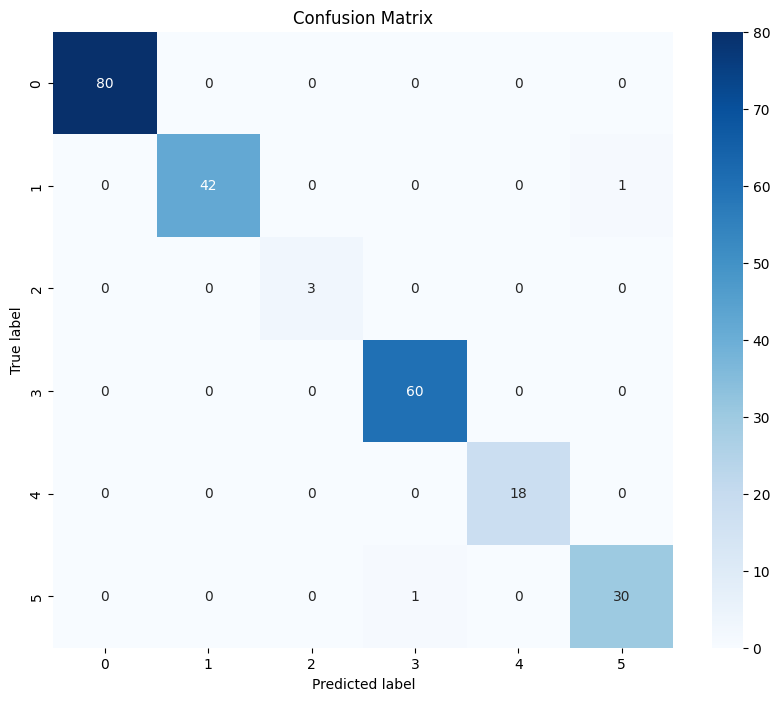

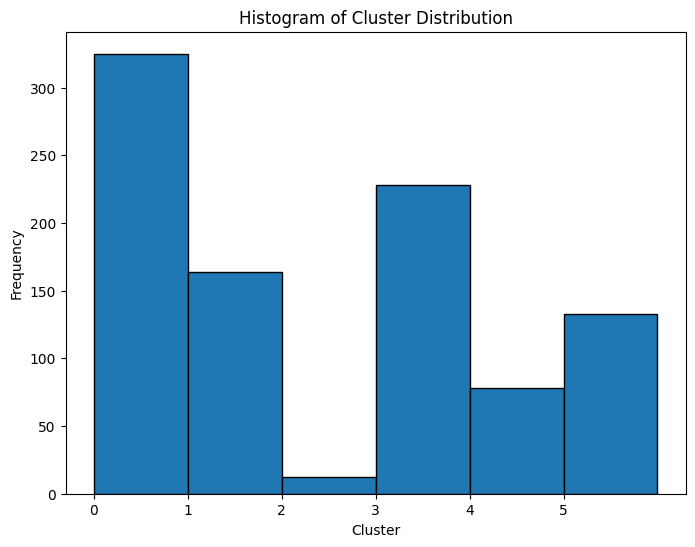

In [29]:
#with hyperparameter tuning with gridsearch cv

import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import AgglomerativeClustering
from sklearn.svm import SVC
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from nltk.tokenize import word_tokenize
import PyPDF2

# Read job descriptions and skills dataset
job_desc_df = pd.read_csv('indeed_dataset.csv', encoding="latin-1")
skills_df = pd.read_csv('skills1.csv')

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in word_tokenize(text) if word.isalpha()])  # Remove non-alphabetic characters
    return text

# Extract skills from job descriptions
def extract_skills(text, skills_df):
    skills = set()
    for skill in skills_df['skills']:
        if skill.lower() in text.lower():
            skills.add(skill.lower())
    return list(skills)

# Create a list of skills extracted from job descriptions
all_skills = []
for text in job_desc_df['description']:
    skills = extract_skills(text, skills_df)
    all_skills.extend(skills)

# Train Word2Vec model on extracted skills
word2vec_model_skills = Word2Vec([all_skills], min_count=1)

# Function to get vector representation of a text
def get_text_vector(text, model):
    tokens = word_tokenize(text)
    vector = np.zeros(model.vector_size)
    count = 0
    for token in tokens:
        if token in model.wv.index_to_key:
            vector += model.wv[token]
            count += 1
    if count != 0:
        vector /= count
    return vector

# Cluster job descriptions based on skill vectors
job_desc_df['vector'] = job_desc_df['description'].apply(lambda x: get_text_vector(x, word2vec_model_skills))
X = np.array(job_desc_df['vector'].tolist())
clustering = AgglomerativeClustering(n_clusters=6)
job_desc_df['cluster'] = clustering.fit_predict(X)

# Define the parameter grid for grid search
param_grid = {
    'svc__C': [0.1, 1, 10, 100],  # Regularization parameter
    'svc__kernel': ['linear', 'rbf', 'poly'],  # Kernel type
}

# Perform grid search
grid_search = GridSearchCV(svm_clf, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from grid search
best_params_grid = grid_search.best_params_
print("Best Hyperparameters (Grid Search):", best_params_grid)
# Prepare data for classification
X_train, X_test, y_train, y_test = train_test_split(X, job_desc_df['cluster'], test_size=0.25, random_state=42)

# Remove the 'svc__' prefix from the keys in the best_params dictionary
cleaned_params = {key.split('__')[1]: value for key, value in best_params.items()}

# Update the SVM classifier with the best hyperparameters
best_svm_clf = make_pipeline(StandardScaler(), SVC(**cleaned_params))

# Train the SVM classifier with the best hyperparameters
best_svm_clf.fit(X_train, y_train)
# Function to extract text from a PDF file
def extract_text_from_pdf(file_path):
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page_num in range(len(reader.pages)):
            text += reader.pages[page_num].extract_text()
    return text

# Extract text from your resume PDF
resume_text = extract_text_from_pdf('resume_yash.pdf')

# Preprocess resume text
resume_text = preprocess_text(resume_text)

# Extract skills from resume
resume_skills = extract_skills(resume_text, skills_df)

# Join the list of skills into a single string
resume_skills_text = ' '.join(resume_skills)

# Predict cluster for resume
predicted_cluster = best_svm_clf.predict([get_text_vector(resume_skills_text, word2vec_model_skills)])[0]



# Calculate precision, recall, and F1 score for classification model
y_pred = best_svm_clf.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print("\nClassification Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print()
print("\nSkills Extracted from Resume:", resume_skills)
print()
# Find top 5 jobs based on Euclidean distance
job_desc_df['euclidean_distance'] = job_desc_df['vector'].apply(lambda x: euclidean_distances([get_text_vector(resume_text, word2vec_model_skills)], [x])[0][0])
similar_jobs = job_desc_df[job_desc_df['cluster'] == predicted_cluster].sort_values(by='euclidean_distance').head(5)

print("\nTop 5 Similar Jobs with Title, Link, Skills, and Euclidean Similarity:")
for index, row in similar_jobs.iterrows():
    print("\nTitle:", row['title'])
    print("Link:", row['link'])
    print("Euclidean Similarity:", row['euclidean_distance'])
    job_skills = extract_skills(row['description'], skills_df)  # Get skills for each job from job descriptions
    print("Skills from Job Description:", job_skills)


conf_mat = confusion_matrix(y_test, y_pred, labels=np.arange(6))

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

##histogram of cluster distribution
plt.figure(figsize=(8, 6))
plt.hist(job_desc_df['cluster'], bins=range(7), edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Histogram of Cluster Distribution')
plt.xticks(range(6))
plt.show()

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters (Grid Search): {'svc__C': 100, 'svc__kernel': 'rbf'}

Classification Metrics:
Accuracy: 0.9914893617021276
Precision: 0.9915591210324382
Recall: 0.9914893617021276
F1 Score: 0.9914819143764416


Skills Extracted from Resume: ['functional', 'backend ', 'express', 'android', 'data ', 'r', ' development ', 'languages', 'java', 'database ', 'chef', 'go', 'frontend', 'kotlin', 'git', ' engineering ', 'sql', 'cloud ']


Top 5 Similar Jobs with Title, Link, Skills, and Euclidean Similarity:

Title: Consultant ï¿½ï¿½ï¿½ Web Dev
Link: https://www.indeed.co.in/rc/clk?jk=59edad14d3066caa&from=jasx&tk=1hng1miccic9i800&bb=BmxtsrZZsRS2o0pZPm2ozP3Fv6kReVuXFLfSttdgFN8s17Xf9uL7KGJD88v6bnCn81ALBbmYOpCmGz-SgMClusPzKZzPT8WMGq0kokLmL2M1T6M3HpgUVQ%3D%3D&xkcb=SoDp67M3EwLVlPQFgJ0BbzkdCdPP&vjs=3
Euclidean Similarity: 0.03930830017069156
Skills from Job Description: ['html', 'angular', 'docker', 'data ', 'languages', 'r', 'sql', '

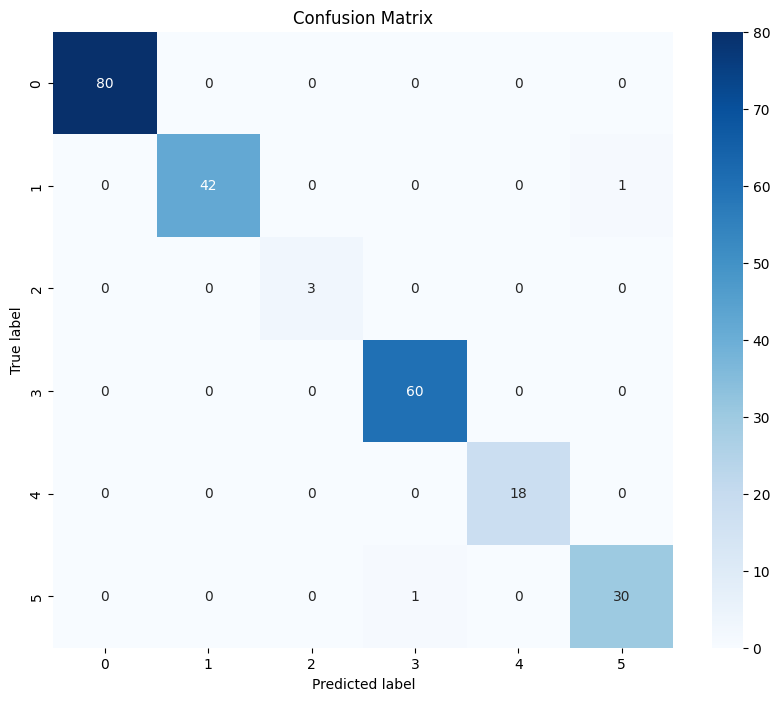

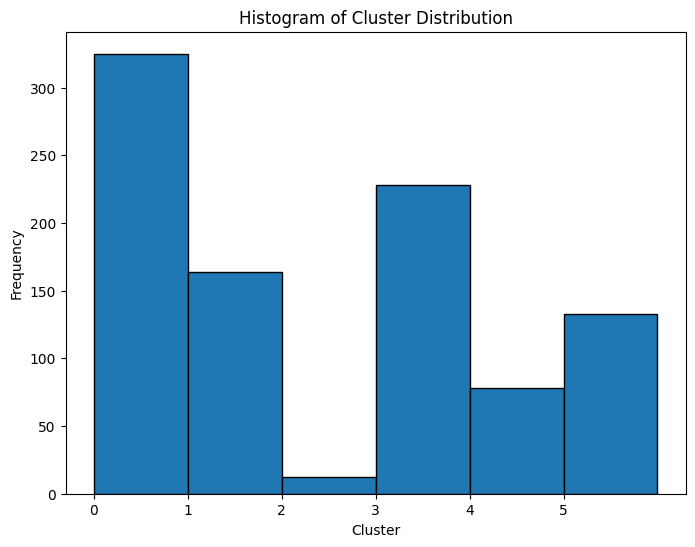

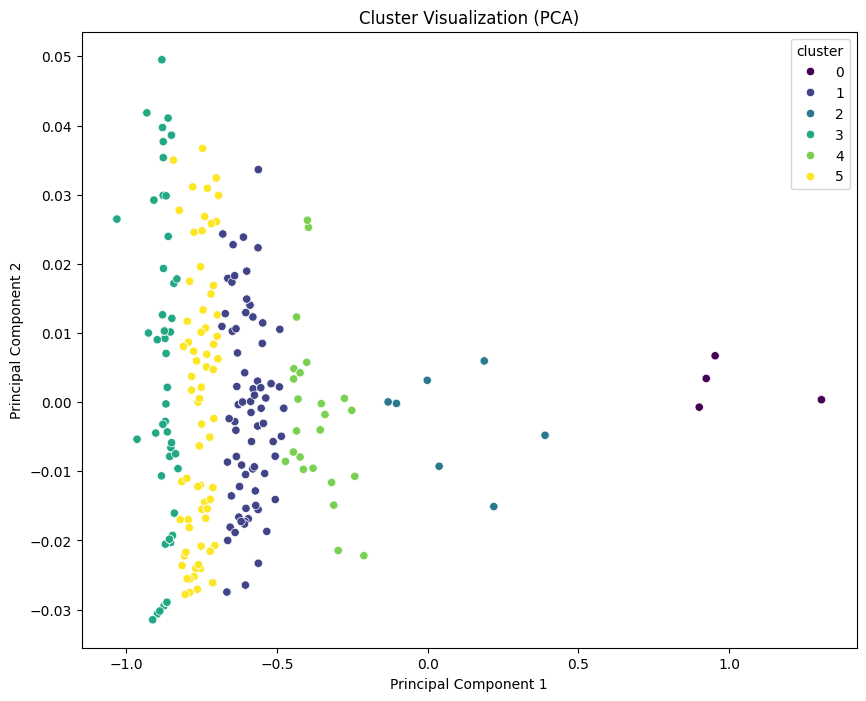

In [31]:
#with hyperparameter tuning with gridsearch cv

import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import AgglomerativeClustering
from sklearn.svm import SVC
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
import PyPDF2

# Read job descriptions and skills dataset
job_desc_df = pd.read_csv('indeed_dataset.csv', encoding="latin-1")
skills_df = pd.read_csv('skills1.csv')

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in word_tokenize(text) if word.isalpha()])  # Remove non-alphabetic characters
    return text

# Extract skills from job descriptions
def extract_skills(text, skills_df):
    skills = set()
    for skill in skills_df['skills']:
        if skill.lower() in text.lower():
            skills.add(skill.lower())
    return list(skills)

# Create a list of skills extracted from job descriptions
all_skills = []
for text in job_desc_df['description']:
    skills = extract_skills(text, skills_df)
    all_skills.extend(skills)

# Train Word2Vec model on extracted skills
word2vec_model_skills = Word2Vec([all_skills], min_count=1)

# Function to get vector representation of a text
def get_text_vector(text, model):
    tokens = word_tokenize(text)
    vector = np.zeros(model.vector_size)
    count = 0
    for token in tokens:
        if token in model.wv.index_to_key:
            vector += model.wv[token]
            count += 1
    if count != 0:
        vector /= count
    return vector

# Cluster job descriptions based on skill vectors
job_desc_df['vector'] = job_desc_df['description'].apply(lambda x: get_text_vector(x, word2vec_model_skills))
X = np.array(job_desc_df['vector'].tolist())
clustering = AgglomerativeClustering(n_clusters=6)
job_desc_df['cluster'] = clustering.fit_predict(X)

# Define the parameter grid for grid search
param_grid = {
    'svc__C': [0.1, 1, 10, 100],  # Regularization parameter
    'svc__kernel': ['linear', 'rbf', 'poly'],  # Kernel type
}

# Perform grid search
grid_search = GridSearchCV(svm_clf, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from grid search
best_params_grid = grid_search.best_params_
print("Best Hyperparameters (Grid Search):", best_params_grid)
# Prepare data for classification
X_train, X_test, y_train, y_test = train_test_split(X, job_desc_df['cluster'], test_size=0.25, random_state=42)

# Remove the 'svc__' prefix from the keys in the best_params dictionary
cleaned_params = {key.split('__')[1]: value for key, value in best_params.items()}

# Update the SVM classifier with the best hyperparameters
best_svm_clf = make_pipeline(StandardScaler(), SVC(**cleaned_params))

# Train the SVM classifier with the best hyperparameters
best_svm_clf.fit(X_train, y_train)
# Function to extract text from a PDF file
def extract_text_from_pdf(file_path):
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page_num in range(len(reader.pages)):
            text += reader.pages[page_num].extract_text()
    return text

# Extract text from your resume PDF
resume_text = extract_text_from_pdf('resume_yash.pdf')

# Preprocess resume text
resume_text = preprocess_text(resume_text)

# Extract skills from resume
resume_skills = extract_skills(resume_text, skills_df)

# Join the list of skills into a single string
resume_skills_text = ' '.join(resume_skills)

# Predict cluster for resume
predicted_cluster = best_svm_clf.predict([get_text_vector(resume_skills_text, word2vec_model_skills)])[0]



# Calculate precision, recall, and F1 score for classification model
y_pred = best_svm_clf.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print("\nClassification Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print()
print("\nSkills Extracted from Resume:", resume_skills)
print()
# Find top 5 jobs based on Euclidean distance
job_desc_df['euclidean_distance'] = job_desc_df['vector'].apply(lambda x: euclidean_distances([get_text_vector(resume_text, word2vec_model_skills)], [x])[0][0])
similar_jobs = job_desc_df[job_desc_df['cluster'] == predicted_cluster].sort_values(by='euclidean_distance').head(5)

print("\nTop 5 Similar Jobs with Title, Link, Skills, and Euclidean Similarity:")
for index, row in similar_jobs.iterrows():
    print("\nTitle:", row['title'])
    print("Link:", row['link'])
    print("Euclidean Similarity:", row['euclidean_distance'])
    job_skills = extract_skills(row['description'], skills_df)  # Get skills for each job from job descriptions
    print("Skills from Job Description:", job_skills)


conf_mat = confusion_matrix(y_test, y_pred, labels=np.arange(6))

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

##histogram of cluster distribution
plt.figure(figsize=(8, 6))
plt.hist(job_desc_df['cluster'], bins=range(7), edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Histogram of Cluster Distribution')
plt.xticks(range(6))
plt.show()

# Reduce dimensionality of vectors for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=job_desc_df['cluster'], palette='viridis', legend='full')
plt.title('Cluster Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()